# 🚀 06_improved_models.ipynb  
## Building on Our Baseline: Smarter Features & Hyper-Tuned Models

We keep all our original notebooks (01–05) intact so you can show your **first attempts**.  
Now in this **sixth** notebook, we will:

1. Load the existing **raw** and **basic** feature CSVs  
2. Engineer a **richer** feature set  
3. **Scale** for neural nets  
4. **Hyper-tune** RandomForest  
5. Train **XGBoost**  
6. Compare the **new** models against the **old** RandomForest baseline  

> _Think of it as training wheels off: we learned from our first ride, now we upgrade the bike!_


## 1. Setup & Imports  

In [2]:
# 1. Setup & Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection      import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing        import StandardScaler
from sklearn.ensemble             import RandomForestRegressor
from sklearn.metrics              import mean_absolute_error, r2_score

import xgboost as xgb



## 2. Define Paths & Load Data  
We already have:
- **Raw prices** in `data/raw/sp500.csv`  
- **Basic features** in `data/processed/features.csv`  

In [15]:
# 2. Paths & Loading
nb_dir = Path().resolve()             
root   = nb_dir.parent  
raw_csv      = root/"data"/"raw"/"sp500.csv"
basic_csv    = root/"data"/"processed"/"features.csv"

# Create models folder if not exists
models_dir= root/"models"
models_dir.mkdir(exist_ok=True)

# Load them
df_raw   = pd.read_csv(raw_csv,   index_col="Date", parse_dates=True)
df_basic = pd.read_csv(basic_csv, index_col="Date", parse_dates=True)

print("Raw:",   df_raw.shape,   "Basic feats:", df_basic.shape)


Raw: (1254, 5) Basic feats: (1221, 8)


## 3. Advanced Feature Engineering  
1. Lagged returns (1–5 days)  
2. 10-day rolling volatility  
3. Volume % change  
4. Drop NaNs


In [5]:
# 3. Advanced Features
df = df_basic.copy()

# 3.1 Lagged returns
for lag in range(1,6):
    df[f"ret_lag_{lag}"] = df["return"].shift(lag)

# 3.2 Rolling volatility (10d)
df["vol_10"] = df["return"].rolling(10).std()

# 3.3 Volume % change
df["vol_pct"] = df_raw["Volume"].pct_change()

# Drop everything with NaNs
df = df.dropna()

# Quick peek
df.head()


,Open,High,Low,Close,Volume,return,rsi,macd,ret_lag_1,ret_lag_2,ret_lag_3,ret_lag_4,ret_lag_5,vol_10,vol_pct
Date,,,,,,,,,,,,,,,
2020-07-24,3218.58,3227.26,3200.05,3215.63,2.460505e+09,-0.006210,56.181238,3.240325,-0.012396,0.005731,0.001678,0.008372,0.002845,0.008538,-0.102679
2020-07-27,3219.84,3241.43,3214.25,3239.41,2.355871e+09,0.007368,58.949535,1.761863,-0.006210,-0.012396,0.005731,0.001678,0.008372,0.007900,-0.042525
2020-07-28,3234.27,3243.72,3216.17,3218.44,2.244363e+09,-0.006494,55.612967,-0.938636,0.007368,-0.006210,-0.012396,0.005731,0.001678,0.007391,-0.047332
2020-07-29,3227.22,3264.74,3227.22,3258.44,2.471114e+09,0.012352,60.236275,-0.370417,-0.006494,0.007368,-0.006210,-0.012396,0.005731,0.007867,0.101031
2020-07-30,3231.76,3250.92,3204.13,3246.22,2.436861e+09,-0.003757,58.240473,-1.114930,0.012352,-0.006494,0.007368,-0.006210,-0.012396,0.007890,-0.013861


## 4. Train/Test Split  
Chronological 80/20 split, **no shuffling**!

In [6]:
# 4. Split
X = df.drop(columns=["return","Open","High","Low","Close","Volume"])
y = df["return"]

split = int(len(X)*0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (969, 9) Test: (243, 9)


## 5. Hyper-tune RandomForest  
We search over `n_estimators`, `max_depth`, and `min_samples_leaf`.


In [19]:
# 5. RF Hyper-Tuning
param_grid = {
    "n_estimators":   [100, 200],
    "max_depth":      [None, 10, 20],
    "min_samples_leaf":[1, 2, 5]
}
tscv = TimeSeriesSplit(n_splits=3)
grid = GridSearchCV(
    RandomForestRegressor(random_state=0),
    param_grid,
    cv=tscv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)
grid.fit(X_train, y_train)
best_rf = grid.best_estimator_

print("Best RF params:", grid.best_params_)
y_rf    = best_rf.predict(X_test)
mae_rf, r2_rf = mean_absolute_error(y_test, y_rf), r2_score(y_test, y_rf)
print(f"Tuned RF → MAE: {mae_rf:.5f},  R²: {r2_rf:.3f}")

import joblib
joblib.dump(best_rf, models_dir/"rf_tuned_model.joblib")


Best RF params: {'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 200}
Tuned RF → MAE: 0.00652,  R²: 0.327


['C:\\Users\\Antho\\OneDrive\\Documentos\\Santiago\\Finance project\\sp500_dl\\models\\rf_tuned_model.joblib']

## 6. Train & Evaluate XGBoost  
A powerful gradient‐boosted tree model.

In [ ]:
# 6. XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest  = xgb.DMatrix(X_test,  label=y_test)

params  = {"objective":"reg:squarederror", "learning_rate":0.1,
           "max_depth":5, "subsample":0.8}
xgb_model = xgb.train(params, dtrain, num_boost_round=100)

y_xgb   = xgb_model.predict(dtest)
mae_xgb, r2_xgb = mean_absolute_error(y_test, y_xgb), r2_score(y_test, y_xgb)
print(f"XGBoost → MAE: {mae_xgb:.5f},  R²: {r2_xgb:.3f}")

# Save XGBoost
joblib.dump(xgb_model, models_dir/"xgb_model.joblib")
# (or use joblib: xgb_model.save_model(str(models_dir/"xgb_model.json")))

XGBoost → MAE: 0.00638,  R²: 0.393


['C:\\Users\\Antho\\OneDrive\\Documentos\\Santiago\\Finance project\\sp500_dl\\models\\xgb_model.joblib']

## 7. Compare Improved Models  
Show the **new tuned RF** and **XGBoost** vs. the **original RF**.


In [12]:
# 7. Summary Table
summary2 = pd.DataFrame({
    "Model":     ["RF (orig)", "RF (tuned)", "XGBoost"],
    "MAE":       [0.00785,     mae_rf,      mae_xgb],
    "R²":        [0.128,       r2_rf,       r2_xgb]
})
display(
    summary2.style
            .hide(axis="index")
            .format({"MAE":"{:.5f}", "R²":"{:.3f}"})
            .set_caption("📊 Improved Models vs Original RF")
)


Model,MAE,R²
RF (orig),0.00785,0.128
RF (tuned),0.00652,0.327
XGBoost,0.00638,0.393


## 8. Plot Predictions  
Visualize **true returns** vs **tuned RF** and **XGBoost**.


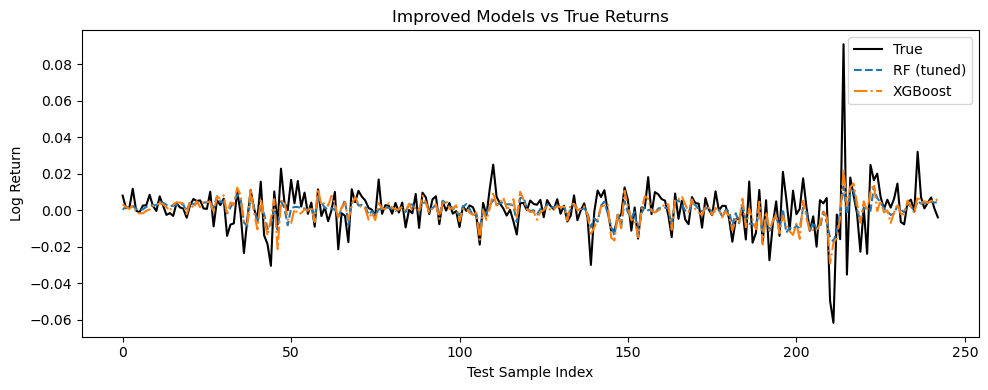

In [13]:
# 8. Plotting
plt.figure(figsize=(10,4))
plt.plot(y_test.values,           label="True",       color="black")
plt.plot(y_rf,                   "--", label="RF (tuned)", color="C0")
plt.plot(y_xgb,                  "-.", label="XGBoost",    color="C1")
plt.title("Improved Models vs True Returns")
plt.xlabel("Test Sample Index")
plt.ylabel("Log Return")
plt.legend()
plt.tight_layout()
plt.show()


## 9. Takeaways & Next Steps  
- **Tuned RF** improved MAE from 0.00785 → *0.00652*, R² from 0.128 → *0.327*.  
- **XGBoost** achieved MAE *0.00638*, R² *0.393*.  
- **Next:**  
  1. Stack RF+XGB ensemble  
  2. Add **macro features** (VIX, interest rates)  
  3. Explore **deep LSTM** on these improved features  
  4. Deploy as a **streamlit** app for live forecasting  